<a href="https://colab.research.google.com/github/Zekeriya-Ui/Brownian-motion/blob/main/GWP2_9710.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Modeling

## 1. Setup and Data Download

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.stattools import adfuller

In [ ]:
# SPY for Non-Stationarity
spy_full = yf.download("SPY", start="2010-01-01", end="2024-06-01",auto_adjust=True)
AAPL_full = yf.download("SPY", start="2010-01-01", end="2024-06-01",auto_adjust=True)

# Tech Stocks for Multicollinearity
tech = yf.download(["AAPL", "MSFT", "GOOG"], start="2020-01-01", end="2024-06-01")['Close']

# TSLA for Feature Extraction
tsla = yf.download("TSLA", start="2023-01-01", end="2024-06-01",auto_adjust=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-43-2967099391.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tech = yf.download(["AAPL", "MSFT", "GOOG"], start="2020-01-01", end="2024-06-01")['Close']
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  1 of 1 completed


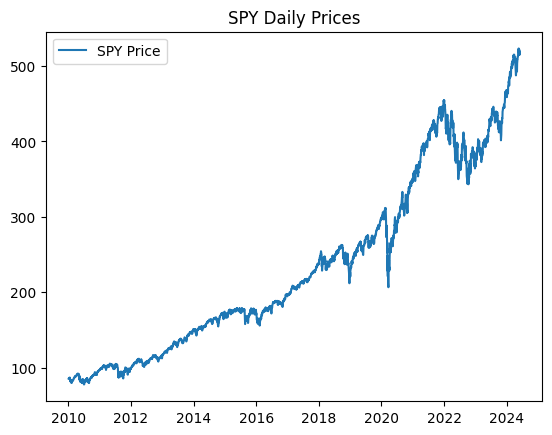

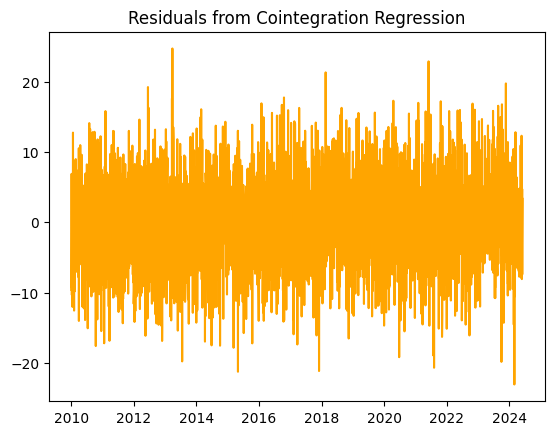

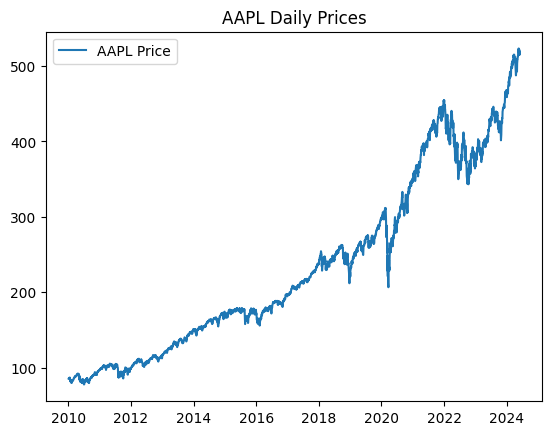

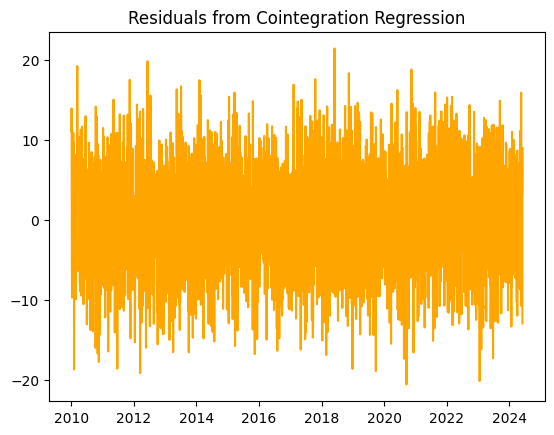

ADF Statistic SPY: -35.02506682303848, p-value: 0.0
ADF Statistic AAPL: -61.48018052831143, p-value: 0.0


In [ ]:
spy = spy_full[['Close']].dropna().reset_index()
AAPL = AAPL_full[['Close']].dropna().reset_index()
# Generate synthetic X with .squeeze() to flatten 'Close'
spy['X'] = spy['Close'].squeeze() * 0.8 + np.random.normal(0, 5, len(spy))
AAPL['X'] = AAPL['Close'].squeeze() * 0.8 + np.random.normal(0, 5, len(AAPL))

# Cointegration Regression
model = sm.OLS(spy['Close'], sm.add_constant(spy['X'])).fit()
spy['residuals'] = model.resid

model = sm.OLS(AAPL['Close'], sm.add_constant(AAPL['X'])).fit()
AAPL['residuals'] = model.resid

# Plot Prices and Residuals
plt.plot(spy['Date'], spy['Close'], label='SPY Price')
plt.title('SPY Daily Prices')
plt.legend()
plt.show()

plt.plot(spy['Date'], spy['residuals'], color='orange')
plt.title('Residuals from Cointegration Regression')
plt.show()


plt.plot(spy['Date'], AAPL['Close'], label='AAPL Price')
plt.title('AAPL Daily Prices')
plt.legend()
plt.show()

plt.plot(AAPL['Date'], AAPL['residuals'], color='orange')
plt.title('Residuals from Cointegration Regression')
plt.show()


# ADF test on residuals
result = adfuller(spy['residuals'])
print(f"ADF Statistic SPY: {result[0]}, p-value: {result[1]}")

result_aapl = adfuller(AAPL['residuals'])
print(f"ADF Statistic AAPL: {result_aapl[0]}, p-value: {result_aapl[1]}")

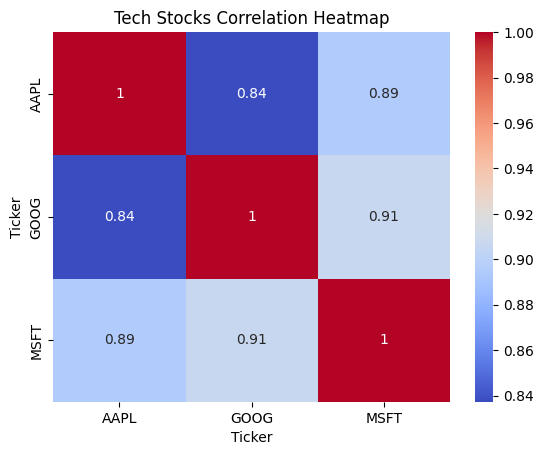

  feature        VIF
0   const  19.536091
1    AAPL   5.114872
2    GOOG   5.716465
3    MSFT   8.572264


In [ ]:
tech = tech.dropna()
sns.heatmap(tech.corr(), annot=True, cmap='coolwarm')
plt.title('Tech Stocks Correlation Heatmap')
plt.show()

# VIF
X = add_constant(tech)
vif = pd.DataFrame({
    'feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
print(vif)

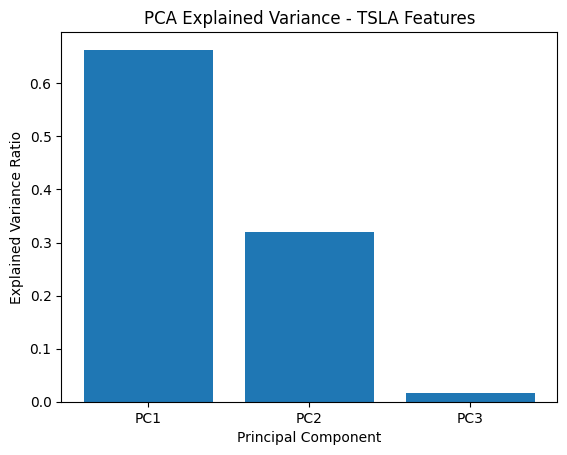

In [ ]:
# Keep 'Close' column only
tsla = tsla[['Close']].dropna().copy()

# Rename for consistency
tsla.rename(columns={'Close': 'Price'}, inplace=True)
tsla['RollingMean'] = tsla['Price'].rolling(10).mean()
tsla['Volatility'] = tsla['Price'].rolling(10).std()

features = tsla.dropna()[['Price', 'RollingMean', 'Volatility']]
scaled = StandardScaler().fit_transform(features)
pca = PCA(n_components=3)
pca.fit(scaled)

plt.bar(range(1, 4), pca.explained_variance_ratio_, tick_label=['PC1', 'PC2', 'PC3'])
plt.title('PCA Explained Variance - TSLA Features')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()